In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import random
random.seed(1100038344)
import survivalstan
import numpy as np
import pandas as pd
from stancache import stancache
from matplotlib import pyplot as plt

INFO:stancache.seed:Setting seed to 1245502385


## The model

This style of modeling is often called the "piecewise exponential model", or PEM. It is the simplest case where we estimate the *hazard* of an event occurring in a time period as the outcome, rather than estimating the *survival* (ie, time to event) as the outcome.

Recall that, in the context of survival modeling, we have two models:

1. A model for **Survival ($S$)**, ie the probability of surviving to time $t$:

  $$ S(t)=Pr(Y > t) $$

2. A model for the **instantaneous *hazard* $\lambda$**, ie the probability of a failure event occuring in the interval [$t$, $t+\delta t$], given survival to time $t$:

  $$ \lambda(t) =  \lim_{\delta t \rightarrow 0 } \; \frac{Pr( t \le Y \le t + \delta t | Y > t)}{\delta t} $$


By definition, these two are related to one another by the following equation:

  $$ \lambda(t) = \frac{-S'(t)}{S(t)} $$
  
Solving this, yields the following:

  $$ S(t) = \exp\left( -\int_0^t \lambda(z) dz \right) $$

This model is called the **piecewise exponential model** because of this relationship between the Survival and hazard functions.  It's piecewise because we are not estimating the *instantaneous* hazard; we are instead breaking time periods up into pieces and estimating the hazard for each piece.

There are several variations on the PEM model implemented in `survivalstan`. In this notebook, we are exploring just one of them.

### A note about data formatting 

When we model *Survival*, we typically operate on data in time-to-event form. In this form, we have one record per `Subject` (ie, per patient). Each record contains `[event_status, time_to_event]` as the outcome. This data format is sometimes called *per-subject*.

When we model the *hazard* by comparison, we typically operate on data that are transformed to include one record per `Subject` per `time_period`.  This is called *per-timepoint* or *long* form.

All other things being equal, a model for *Survival* will typically estimate more efficiently (faster & smaller memory footprint) than one for *hazard* simply because the data are larger in the per-timepoint form than the per-subject form. The benefit of the *hazard* models is increased flexibility in terms of specifying the baseline hazard, time-varying effects, and introducing time-varying covariates.

In this example, we are demonstrating use of the standard **PEM survival model**, which uses data in long form. The `stan` code expects to recieve data in this structure.

## Stan code for the model

This model is provided in `survivalstan.models.pem_survival_model`. Let's take a look at the stan code. 

In [2]:
print(survivalstan.models.pem_survival_model)

/*  Variable naming:
 // dimensions
 N          = total number of observations (length of data)
 S          = number of sample ids
 T          = max timepoint (number of timepoint ids)
 M          = number of covariates
 
 // main data matrix (per observed timepoint*record)
 s          = sample id for each obs
 t          = timepoint id for each obs
 event      = integer indicating if there was an event at time t for sample s
 x          = matrix of real-valued covariates at time t for sample n [N, X]
 
 // timepoint-specific data (per timepoint, ordered by timepoint id)
 t_obs      = observed time since origin for each timepoint id (end of period)
 t_dur      = duration of each timepoint period (first diff of t_obs)
 
*/
// Jacqueline Buros Novik <jackinovik@gmail.com>

data {
  // dimensions
  int<lower=1> N;
  int<lower=1> S;
  int<lower=1> T;
  int<lower=0> M;
  
  // data matrix
  int<lower=1, upper=N> s[N];     // sample id
  int<lower=1, upper=T> t[N];     // timepoint id
  int<

## Simulate survival data 

In order to demonstrate the use of this model, we will first simulate some survival data using `survivalstan.sim.sim_data_exp_correlated`. As the name implies, this function simulates data assuming a constant hazard throughout the follow-up time period, which is consistent with the Exponential survival function.

This function includes two simulated covariates by default (`age` and `sex`). We also simulate a situation where hazard is a function of the simulated value for `sex`. 

We also center the `age` variable since this will make it easier to interpret estimates of the baseline hazard.


In [3]:
d = stancache.cached(
    survivalstan.sim.sim_data_exp_correlated,
    N=100,
    censor_time=20,
    rate_form='1 + sex',
    rate_coefs=[-3, 0.5],
)
d['age_centered'] = d['age'] - d['age'].mean()

INFO:stancache.stancache:sim_data_exp_correlated: cache_filename set to sim_data_exp_correlated.cached.N_100.censor_time_20.rate_coefs_54462717316.rate_form_1 + sex.pkl
INFO:stancache.stancache:sim_data_exp_correlated: Starting execution
INFO:stancache.stancache:sim_data_exp_correlated: Execution completed (0:00:00.030100 elapsed)
INFO:stancache.stancache:sim_data_exp_correlated: Saving results to cache


*Aside: In order to make this a more reproducible example, this code is using a file-caching function `stancache.cached` to wrap a function call to `survivalstan.sim.sim_data_exp_correlated`. *

## Explore simulated data

Here is what these data look like - this is `per-subject` or `time-to-event` form:

In [4]:
d.head()

,sex,age,rate,true_t,t,event,index,age_centered
0,male,54,0.082085,1.013855,1.013855,True,0,-1.12
1,male,39,0.082085,4.890597,4.890597,True,1,-16.12
2,female,45,0.049787,4.093404,4.093404,True,2,-10.12
3,female,43,0.049787,7.036226,7.036226,True,3,-12.12
4,female,57,0.049787,5.712299,5.712299,True,4,1.88


*It's not that obvious from the field names, but in this example "subjects" are indexed by the field `index`.*

We can plot these data using `lifelines`, or the rudimentary plotting functions provided by `survivalstan`.

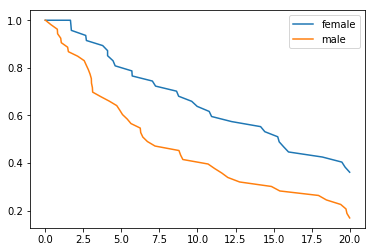

In [5]:
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='female'], event_col='event', time_col='t', label='female')
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='male'], event_col='event', time_col='t', label='male')
plt.legend()

## Transform to `long` or `per-timepoint` form

Finally, since this is a PEM model, we transform our data to `long` or `per-timepoint` form.

In [6]:
dlong = stancache.cached(
    survivalstan.prep_data_long_surv,
    df=d, event_col='event', time_col='t'
)

INFO:stancache.stancache:prep_data_long_surv: cache_filename set to prep_data_long_surv.cached.df_14209590808.event_col_event.time_col_t.pkl
INFO:stancache.stancache:prep_data_long_surv: Starting execution
INFO:stancache.stancache:prep_data_long_surv: Execution completed (0:00:00.829609 elapsed)
INFO:stancache.stancache:prep_data_long_surv: Saving results to cache


We now have one record per timepoint (distinct values of `end_time`) per subject (`index`, in the original data frame).

In [7]:
dlong.query('index == 1').sort_values('end_time')

,sex,age,rate,true_t,t,event,index,age_centered,end_time,end_failure
148,male,39,0.082085,4.890597,4.890597,True,1,-16.12,0.009787,False
140,male,39,0.082085,4.890597,4.890597,True,1,-16.12,0.377535,False
147,male,39,0.082085,4.890597,4.890597,True,1,-16.12,0.791192,False
133,male,39,0.082085,4.890597,4.890597,True,1,-16.12,0.808987,False
75,male,39,0.082085,4.890597,4.890597,True,1,-16.12,1.013855,False
128,male,39,0.082085,4.890597,4.890597,True,1,-16.12,1.052508,False
106,male,39,0.082085,4.890597,4.890597,True,1,-16.12,1.467963,False
102,male,39,0.082085,4.890597,4.890597,True,1,-16.12,1.517398,False
118,male,39,0.082085,4.890597,4.890597,True,1,-16.12,1.653389,False
123,male,39,0.082085,4.890597,4.890597,True,1,-16.12,1.684769,False


## Fit stan model

Now, we are ready to fit our model using `survivalstan.fit_stan_survival_model`. 

We pass a few parameters to the fit function, many of which are required. See ?survivalstan.fit_stan_survival_model for details. 

Similar to what we did above, we are asking `survivalstan` to cache this model fit object. See [stancache](http://github.com/jburos/stancache) for more details on how this works. Also, if you didn't want to use the cache, you could omit the parameter `FIT_FUN` and `survivalstan` would use the standard pystan functionality.


In [8]:
testfit = survivalstan.fit_stan_survival_model(
    model_cohort = 'test model',
    model_code = survivalstan.models.pem_survival_model,
    df = dlong,
    sample_col = 'index',
    timepoint_end_col = 'end_time',
    event_col = 'end_failure',
    formula = '~ age_centered + sex',
    iter = 5000,
    chains = 4,
    seed = 9001,
    FIT_FUN = stancache.cached_stan_fit,
    )


/home/jacki/projects/survivalstan/survivalstan/formulas.py:96: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.stan_data = stan_data
/home/jacki/projects/survivalstan/survivalstan/formulas.py:97: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.meta_data = meta_data
/home/jacki/projects/survivalstan/survivalstan/formulas.py:96: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.stan_data = stan_data
/home/jacki/projects/survivalstan/survivalstan/formulas.py:97: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.me

## Superficial review of convergence

We will note here some top-level summaries of posterior draws -- this is a minimal example so it's unlikely that this model converged very well. 

In practice, you would want to do a lot more investigation of convergence issues, etc. For now the goal is to demonstrate the functionalities available here.

We can summarize posterior estimates for a single parameter, (e.g. the built-in Stan parameter `lp__`):

In [9]:
survivalstan.utils.print_stan_summary([testfit], pars='lp__')

            mean   se_mean         sd        2.5%        50%       97.5%      Rhat
lp__ -256.245261  7.250135  61.205869 -354.759693 -263.50142 -140.138717  1.051442


Or, for sets of parameters with the same name:

In [10]:
survivalstan.utils.print_stan_summary([testfit], pars='log_baseline_raw')

                          mean   se_mean        sd      2.5%       50%     97.5%      Rhat
log_baseline_raw[1]   0.018132  0.001824  0.129923 -0.229324  0.006289  0.328029  1.001014
log_baseline_raw[2]   0.014313  0.001528  0.130757 -0.252221  0.005191  0.325875  1.000863
log_baseline_raw[3]   0.012711  0.001217  0.128266 -0.246799  0.004697  0.313802  0.999908
log_baseline_raw[4]   0.012407  0.001245  0.132321 -0.268312  0.004217  0.320704  1.000380
log_baseline_raw[5]   0.010461  0.001241  0.128665 -0.254925  0.004515  0.305921  1.000259
log_baseline_raw[6]   0.011580  0.001312  0.124332 -0.238816  0.004884  0.301659  1.000715
log_baseline_raw[7]   0.009081  0.000985  0.123191 -0.250787  0.005060  0.286061  1.000305
log_baseline_raw[8]   0.007947  0.001117  0.129695 -0.257251  0.002758  0.295658  0.999792
log_baseline_raw[9]   0.009325  0.001051  0.128730 -0.265850  0.002783  0.313653  1.000464
log_baseline_raw[10]  0.010481  0.001140  0.127712 -0.251433  0.003451  0.303536  1.000084

It's also not uncommon to graphically summarize the `Rhat` values, to get a sense of similarity among the chains for particular parameters.  

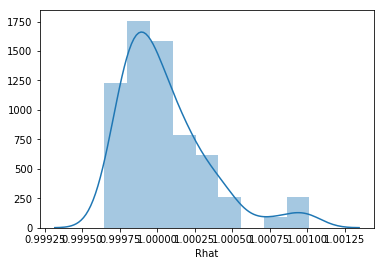

In [11]:
survivalstan.utils.plot_stan_summary([testfit], pars='log_baseline_raw')

## Plot posterior estimates of parameters

We can use `plot_coefs` to summarize posterior estimates of parameters. 

In this basic `pem_survival_model`, we estimate a parameter for baseline hazard for each observed timepoint which is then adjusted for the duration of the timepoint.  For consistency, the baseline values are normalized to the *unit time* given in the input data. This allows us to compare hazard estimates across timepoints without having to know the duration of a timepoint. *(in general, the duration-adjusted hazard paramters are suffixed with `_raw` whereas those which are unit-normalized do not have a suffix).*

In this model, the baseline hazard is parameterized by two components -- there is an overall mean across all timepoints (`log_baseline_mu`) and some variance per timepoint (`log_baseline_tp`). The degree of variance is estimated from the data as `log_baseline_sigma`. All components have weak default priors. See the stan code above for details.

In this case, the model estimates a minimal degree of variance across timepoints, which is good given that the simulated data assumed a constant hazard over time. 


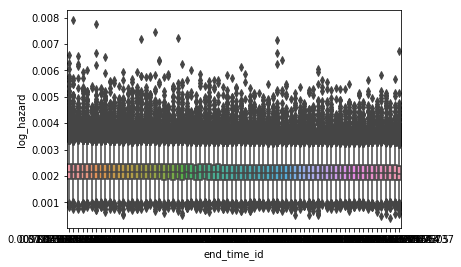

In [12]:
survivalstan.utils.plot_coefs([testfit], element='baseline')

We can also summarize the posterior estimates for our `beta` coefficients. This is actually the default behavior of `plot_coefs`. Here we hope to see the posterior estimates of beta coefficients include the value we used for our simulation (0.5).

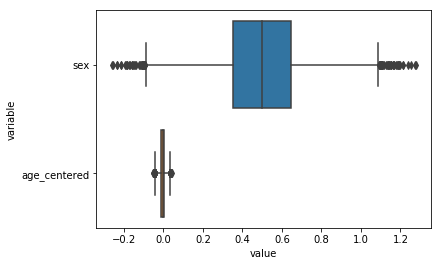

In [13]:
survivalstan.utils.plot_coefs([testfit])

## Posterior predictive checking

Finally, `survivalstan` provides some utilities for posterior predictive checking.

The goal of posterior-predictive checking is to compare the uncertainty of model predictions to observed values.

We are not doing *true* out-of-sample predictions, but we are able to sanity-check our model's calibration. We expect approximately 5% of observed values to fall outside of their corresponding 95% posterior-predicted intervals.

By default, `survivalstan`'s plot_pp_survival method will plot whiskers at the 2.5th and 97.5th percentile values, corresponding to 95% predicted intervals.

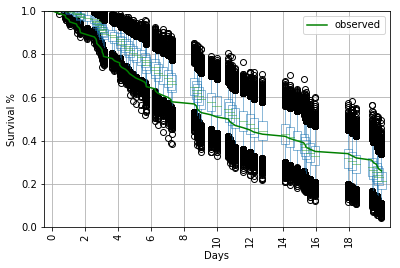

In [19]:
survivalstan.utils.plot_pp_survival([testfit], fill=False)
survivalstan.utils.plot_observed_survival(df=d, event_col='event', time_col='t', color='green', label='observed')
plt.legend()

We can also summarize and plot survival by our covariates of interest, provided they are included in the original dataframe provided to `fit_stan_survival_model`.

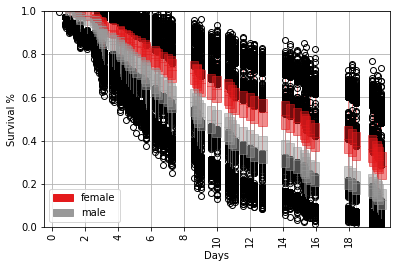

In [20]:
survivalstan.utils.plot_pp_survival([testfit], by='sex')

This plot can also be customized by a variety of aesthetic elements

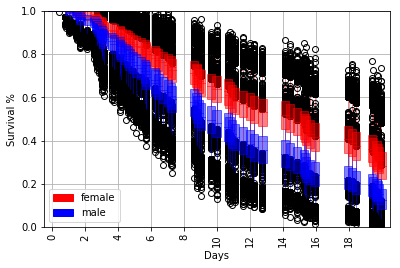

In [21]:
survivalstan.utils.plot_pp_survival([testfit], by='sex', pal=['red', 'blue'])

## Building up the plot semi-manually, for more customization

We can also access the utility methods within `survivalstan.utils` to more or less produce the same plot. This sequence is intended to both illustrate how the above-described plot was constructed, and expose some of the 
functionality in a more concrete fashion.

Probably the most useful element is being able to summarize & return posterior-predicted values to begin with:

In [22]:
ppsurv = survivalstan.utils.prep_pp_survival_data([testfit], by='sex')

Here are what these data look like:

In [23]:
ppsurv.head()

,iter,model_cohort,sex,level_3,event_time,survival
0,0,test model,female,0,0.000000,1.000000
1,0,test model,female,1,2.558112,1.000000
2,0,test model,female,2,3.025977,0.946052
3,0,test model,female,3,3.034875,0.939797
4,0,test model,female,4,3.641794,0.912041


(Note that this itself is a summary of the posterior draws returned by `survivalstan.utils.prep_pp_data`. In this case, the survival stats are summarized by values of `['iter', 'model_cohort', by]`. 

We can then call out to `survivalstan.utils._plot_pp_survival_data` to construct the plot. In this case, we overlay the posterior predicted intervals with observed values.

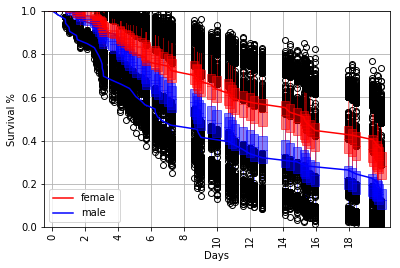

In [24]:
subplot = plt.subplots(1, 1)
survivalstan.utils._plot_pp_survival_data(ppsurv.query('sex == "male"').copy(),
                                          subplot=subplot, color='blue', alpha=0.5)
survivalstan.utils._plot_pp_survival_data(ppsurv.query('sex == "female"').copy(),
                                          subplot=subplot, color='red', alpha=0.5)
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='female'], event_col='event', time_col='t',
                                          color='red', label='female')
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='male'], event_col='event', time_col='t',
                                          color='blue', label='male')
plt.legend()